In [ ]:
# Clean Inter-Subject NeuroBOLT Training with Minimal Progress Bars
# Shows only: Loading bar per epoch + Train/Val MSE, R, Loss

import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add current directory to path
current_dir = '/scratch/vsp7230/Neuroinfo/NeuroBolt_replication/NeuroBOLT'
if current_dir not in sys.path:
    sys.path.append(current_dir)

# Core imports
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
import time
import datetime
import json
import math
import re
from collections import defaultdict
import matplotlib.pyplot as plt

# Progress bar
from tqdm.auto import tqdm

# MNE setup (suppress all output)
import mne
mne.set_log_level('ERROR')

# Model and training imports
from timm.models import create_model
from timm.utils import ModelEma
import models.model
from dataset_maker import preproc
from engine import train_one_epoch, evaluate
from optim_factory import create_optimizer, get_parameter_groups, LayerDecayValueAssigner
from utils import NativeScalerWithGradNormCount as NativeScaler
import utils
from scipy.signal import butter, filtfilt
import pickle

print("✅ All imports successful!")

# =============================================================================
# CONFIGURATION CLASS
# =============================================================================

class Args:
    """Configuration class"""
    def __init__(self):
        # Dataset paths
        self.dataset_root = '/scratch/vsp7230/Neuroinfo/NeuroBolt_replication/Dataset/'
        self.output_dir = '/scratch/vsp7230/Neuroinfo/NeuroBolt_replication/NeuroBOLT/checkpoints/'
        self.log_dir = '/scratch/vsp7230/Neuroinfo/NeuroBolt_replication/NeuroBOLT/log/neurobolt_default/'
        
        # Model parameters
        self.model = 'neurobolt_default'
        self.finetune = '/scratch/vsp7230/Neuroinfo/NeuroBolt_replication/NeuroBOLT/checkpoints/labram-base.pth'
        
        # Inter-subject training parameters
        self.batch_size = 32
        self.epochs = 30
        self.lr = 1e-4
        self.weight_decay = 0.05
        self.warmup_epochs = 5
        self.update_freq = 1
        self.save_ckpt_freq = 5
        
        # Dataset specific
        self.dataset = 'VU'
        self.train_test_mode = 'full_test'
        self.labels_roi = 'Thalamus'
        self.TR = 2.1
        self.mri_sync_event = 'R149'
        self.nb_eegchan = 26
        self.nb_roi = 1
        
        # Model architecture
        self.input_size = 200
        self.drop = 0.1
        self.attn_drop_rate = 0.0
        self.drop_path = 0.1
        self.qkv_bias = False
        self.rel_pos_bias = False
        self.abs_pos_emb = True
        self.layer_scale_init_value = 0.1
        self.use_mean_pooling = True
        self.init_scale = 0.001
        
        # Optimizer
        self.opt = 'adamw'
        self.opt_eps = 1e-8
        self.opt_betas = None
        self.clip_grad = None
        self.momentum = 0.9
        self.layer_decay = 0.65
        self.warmup_lr = 1e-6
        self.min_lr = 1e-6
        self.warmup_steps = -1
        self.weight_decay_end = None
        
        # System
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.seed = 12345
        self.num_workers = 0  # Set to 0 to avoid issues
        self.pin_mem = True
        
        # Misc
        self.model_key = 'model|module'
        self.model_prefix = ''
        self.model_filter_name = 'gzp'
        self.disable_eval_during_finetuning = False
        self.model_ema = False
        self.save_ckpt = True
        self.start_epoch = 0
        self.eval = False
        self.resume = ''
        self.auto_resume = False
        self.enable_deepspeed = False
        self.distributed = False
        self.world_size = 1
        self.local_rank = -1
        self.rank = 0
        self.gpu = 0
        self.dist_eval = False
        self.disable_weight_decay_on_rel_pos_bias = False
        self.prepro_datapath = None
        self.save_input_tensor = False

# =============================================================================
# DATASET DISCOVERY AND SPLIT CREATION
# =============================================================================

def discover_and_split_dataset(dataset_root):
    """Discover dataset and create train/val/test split"""
    
    eeg_dir = os.path.join(dataset_root, 'EEG_set')
    fmri_dir = os.path.join(dataset_root, 'fMRI_difumo64')
    
    # Find files
    eeg_files = [f for f in os.listdir(eeg_dir) if f.endswith('.set')]
    fmri_files = [f for f in os.listdir(fmri_dir) if f.endswith('.pkl')]
    
    # Extract subject-session pairs
    def extract_subject_session(filename):
        match = re.match(r'(sub\d+-scan\d+)', filename)
        return match.group(1) if match else None
    
    eeg_subjects = {extract_subject_session(f) for f in eeg_files if extract_subject_session(f)}
    fmri_subjects = {extract_subject_session(f) for f in fmri_files if extract_subject_session(f)}
    matched_subjects = eeg_subjects.intersection(fmri_subjects)
    
    # Organize by subject
    subject_sessions = defaultdict(list)
    for subj_sess in sorted(matched_subjects):
        subject_match = re.match(r'(sub\d+)', subj_sess)
        if subject_match:
            subject = subject_match.group(1)
            subject_sessions[subject].append(subj_sess)
    
    # Create subject-wise split
    np.random.seed(42)
    subjects = list(subject_sessions.keys())
    np.random.shuffle(subjects)
    
    n_subjects = len(subjects)
    n_train = int(n_subjects * 0.7)
    n_val = int(n_subjects * 0.15)
    
    train_subjects = subjects[:n_train]
    val_subjects = subjects[n_train:n_train + n_val]
    test_subjects = subjects[n_train + n_val:]
    
    # Assign sessions
    train_sessions = []
    val_sessions = []
    test_sessions = []
    
    for subject, sessions in subject_sessions.items():
        if subject in train_subjects:
            train_sessions.extend(sessions)
        elif subject in val_subjects:
            val_sessions.extend(sessions)
        else:
            test_sessions.extend(sessions)
    
    print(f"📊 Dataset: {len(matched_subjects)} sessions, {len(subject_sessions)} subjects")
    print(f"📊 Split: Train={len(train_sessions)}, Val={len(val_sessions)}, Test={len(test_sessions)}")
    
    return {
        'train_sessions': train_sessions,
        'val_sessions': val_sessions,
        'test_sessions': test_sessions,
        'all_sessions': sorted(matched_subjects)
    }

# =============================================================================
# QUIET DATA LOADER
# =============================================================================

def download_vu_dataset_quiet(sub, scan, path_to_dataset, roi_name='Thalamus'):
    """Load EEG and fMRI data without any verbose output"""
    
    patient = f'sub{sub:02d}-scan{scan:02d}'
    eeg_path = os.path.join(path_to_dataset, 'EEG_set', f'{patient}_eeg.set')
    
    if not os.path.exists(eeg_path):
        eeg_path = os.path.join(path_to_dataset, 'EEG_set', f'{patient}_eeg_pp.set')
    
    fmri_path = os.path.join(path_to_dataset, 'fMRI_difumo64', f'{patient}_difumo64_roi.pkl')
    
    if not os.path.exists(fmri_path):
        fmri_path = os.path.join(path_to_dataset, 'fMRI_difumo64', f'{patient}_difumo_roi.pkl')
    
    if not os.path.exists(eeg_path) or not os.path.exists(fmri_path):
        raise FileNotFoundError(f"Files not found for {patient}")
    
    # Load EEG silently
    raw = mne.io.read_raw_eeglab(eeg_path, verbose=False, preload=False)
    original_fps = raw.info['sfreq']
    new_fps = 200
    
    if original_fps != new_fps:
        raw.resample(new_fps, verbose=False)
    
    # Remove non-EEG channels
    if len(raw.ch_names) > 32:
        exclude_channels = ['EOG1', 'EOG2', 'EMG1', 'EMG2', 'EMG3', 'ECG',
                          'CWL1', 'CWL2', 'CWL3', 'CWL4']
    else:
        exclude_channels = ['EOG1', 'EOG2', 'EMG1', 'EMG2', 'EMG3', 'ECG']
    
    exclude_channels = [ch for ch in exclude_channels if ch in raw.ch_names]
    if exclude_channels:
        raw.drop_channels(exclude_channels)
    
    # Load fMRI data
    fmri_df = pd.read_pickle(fmri_path)
    roi_labels = fmri_df.columns.to_list()
    
    return raw, fmri_df, roi_labels

def convert_to_tensor(data):
    """Convert list of arrays to stacked tensor"""
    if len(data) == 0:
        return torch.empty(0)
    tensors = [torch.tensor(arr, dtype=torch.float32) for arr in data]
    return torch.stack(tensors, dim=0)

def prepare_intersubject_dataloader(args, split_info):
    """Prepare data loader with minimal output"""
    
    torch.manual_seed(12345)
    np.random.seed(12345)

    root = args.dataset_root
    tr = args.TR
    event_sync_name = args.mri_sync_event
    tmin, tmax, crop = -16, 0, 3200

    train_sessions = split_info['train_sessions']
    val_sessions = split_info['val_sessions'] 
    test_sessions = split_info['test_sessions']

    eeg_data = {"train": [], "val": [], "test": []}
    fmri_data = {"train": [], "val": [], "test": []}

    all_sessions = train_sessions + val_sessions + test_sessions
    successful = 0
    
    # Simple progress bar for data loading
    with tqdm(all_sessions, desc="Loading data", ncols=80) as pbar:
        for session in pbar:
            sub_match = re.search(r'sub(\d+)', session)
            scan_match = re.search(r'scan(\d+)', session)
            
            if not sub_match or not scan_match:
                continue
                
            sub_ind = int(sub_match.group(1))
            scan_ind = int(scan_match.group(1))
            
            try:
                eeg_raw, fmri_df, _ = download_vu_dataset_quiet(sub_ind, scan_ind, root, args.labels_roi)
                eeg_raw.load_data(verbose=False)
                eeg_raw.filter(l_freq=0.5, h_freq=None, verbose=False)
                
                if args.labels_roi not in fmri_df.columns:
                    continue
                    
                roi_data = fmri_df[args.labels_roi].values
                fmri_np = roi_data.reshape(1, -1)

                # Filter fMRI
                fs = 1 / tr
                nyquist = 0.5 * fs
                low = 0.15 / nyquist
                b, a = butter(N=5, Wn=low, btype='low', analog=False)
                fmri_np = filtfilt(b, a, fmri_np, axis=1)
                fmri_norm, _ = preproc.normalize_data(fmri_np)

                # Epoching
                data_epoch, _ = preproc.epoching_seq2one(
                    eeg_raw, fmri_norm, tmin, tmax, event_sync_name, ifnorm=0, crop=crop
                )

                # Assign to splits
                if session in train_sessions:
                    eeg_data["train"].extend(data_epoch["eeg"])
                    fmri_data["train"].extend(data_epoch["fmri"])
                elif session in val_sessions:
                    eeg_data["val"].extend(data_epoch["eeg"])
                    fmri_data["val"].extend(data_epoch["fmri"])
                elif session in test_sessions:
                    eeg_data["test"].extend(data_epoch["eeg"])
                    fmri_data["test"].extend(data_epoch["fmri"])
                
                successful += 1
                pbar.set_postfix({'Success': successful})
                    
            except Exception:
                continue

    # Convert to tensors
    eeg_tensors = {}
    fmri_tensors = {}
    
    for split in ["train", "val", "test"]:
        if len(eeg_data[split]) > 0:
            eeg_tensors[split] = convert_to_tensor(eeg_data[split])
            fmri_tensors[split] = convert_to_tensor(fmri_data[split]).squeeze()
        else:
            eeg_tensors[split] = torch.zeros(1, 26, 3200)
            fmri_tensors[split] = torch.zeros(1)

    train_dataset = torch.utils.data.TensorDataset(eeg_tensors["train"], fmri_tensors["train"])
    val_dataset = torch.utils.data.TensorDataset(eeg_tensors["val"], fmri_tensors["val"])
    test_dataset = torch.utils.data.TensorDataset(eeg_tensors["test"], fmri_tensors["test"])

    print(f"✅ Loaded: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    return train_dataset, test_dataset, val_dataset

# =============================================================================
# MODEL SETUP
# =============================================================================

def setup_model(args):
    """Setup model with minimal output"""
    
    model = create_model(
        args.model,
        EEG_channel=args.nb_eegchan,
        num_roi=args.nb_roi,
        drop_rate=args.drop,
        drop_path_rate=args.drop_path,
        attn_drop_rate=args.attn_drop_rate,
        use_mean_pooling=args.use_mean_pooling,
        init_scale=args.init_scale,
        use_rel_pos_bias=args.rel_pos_bias,
        use_abs_pos_emb=args.abs_pos_emb,
        init_values=args.layer_scale_init_value,
        qkv_bias=args.qkv_bias,
    )
    
    # Load pretrained weights
    if args.finetune and os.path.exists(args.finetune):
        checkpoint = torch.load(args.finetune, map_location='cpu')
        checkpoint_model = checkpoint.get('model', checkpoint)
        
        # Remove incompatible keys
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                del checkpoint_model[k]
        
        keys_to_remove = [key for key in checkpoint_model.keys() if "relative_position_index" in key]
        for key in keys_to_remove:
            checkpoint_model.pop(key)
        
        utils.load_state_dict(model, checkpoint_model)
        print("✅ Model loaded with pretrained weights")
    else:
        print("⚠️ No pretrained weights")
    
    model.to(args.device)
    return model

# =============================================================================
# CLEAN TRAINING FUNCTIONS
# =============================================================================

def train_epoch_clean(model, train_loader, optimizer, lr_schedule_values, wd_schedule_values, 
                     epoch, device, criterion, loss_scaler, ch_names, update_freq, 
                     num_training_steps_per_epoch):
    """Train one epoch with clean progress bar showing only essential metrics"""
    
    model.train()
    
    # Metrics tracking
    total_loss = 0
    total_corr = 0
    num_batches = 0
    
    # Clean progress bar for training batches
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}", ncols=100, leave=False)
    
    for data_iter_step, (samples, targets) in enumerate(train_pbar):
        step = data_iter_step // update_freq
        if step >= num_training_steps_per_epoch:
            continue
            
        it = epoch * num_training_steps_per_epoch + step
        
        # Update LR & WD
        if data_iter_step % update_freq == 0:
            for i, param_group in enumerate(optimizer.param_groups):
                if lr_schedule_values is not None:
                    param_group["lr"] = lr_schedule_values[it] * param_group.get("lr_scale", 1.0)
                if wd_schedule_values is not None and param_group["weight_decay"] > 0:
                    param_group["weight_decay"] = wd_schedule_values[it]

        # Forward pass
        samples = samples.float().to(device, non_blocking=True) / 100
        samples = samples.view(samples.shape[0], samples.shape[1], 16, 200)  # Reshape for model
        targets = targets.to(device, non_blocking=True).float().unsqueeze(-1)

        with torch.cuda.amp.autocast(enabled=False):
            input_chans = utils.get_input_chans(ch_names) if ch_names else None
            outputs = model(samples, input_chans=input_chans)
            loss = criterion(outputs.float(), targets.float())

        # Backward pass
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss /= update_freq
        loss_scaler(loss, optimizer, clip_grad=None,
                   parameters=model.parameters(), create_graph=is_second_order,
                   update_grad=(data_iter_step + 1) % update_freq == 0)
        
        if (data_iter_step + 1) % update_freq == 0:
            optimizer.zero_grad()

        # Calculate correlation
        with torch.no_grad():
            corr = np.corrcoef(outputs.detach().cpu().numpy().squeeze(), 
                             targets.detach().cpu().numpy().squeeze())[0, 1]
            if np.isnan(corr):
                corr = 0.0
        
        # Update metrics
        total_loss += loss.item() * update_freq
        total_corr += corr
        num_batches += 1
        
        # Update progress bar with current metrics
        avg_loss = total_loss / num_batches
        avg_corr = total_corr / num_batches
        
        train_pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'R': f'{avg_corr:.3f}'
        })

    train_pbar.close()
    
    return {
        'loss': total_loss / num_batches,
        'corr': total_corr / num_batches
    }

def evaluate_clean(data_loader, model, device, ch_names):
    """Evaluate with minimal output"""
    
    criterion = torch.nn.MSELoss()
    model.eval()
    
    total_loss = 0
    total_mse = 0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for samples, targets in data_loader:
            samples = samples.float().to(device, non_blocking=True) / 100
            samples = samples.view(samples.shape[0], samples.shape[1], 16, 200)
            targets = targets.to(device, non_blocking=True).float().unsqueeze(-1)

            with torch.cuda.amp.autocast(enabled=False):
                input_chans = utils.get_input_chans(ch_names) if ch_names else None
                outputs = model(samples, input_chans=input_chans)
                loss = criterion(outputs, targets)

            total_loss += loss.item()
            total_mse += loss.item()
            
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate correlation
    all_outputs = np.concatenate(all_outputs, axis=0).squeeze()
    all_targets = np.concatenate(all_targets, axis=0).squeeze()
    
    corr = np.corrcoef(all_outputs, all_targets)[0, 1]
    if np.isnan(corr):
        corr = 0.0

    return {
        'loss': total_loss / len(data_loader),
        'mse': total_mse / len(data_loader),
        'corr': corr
    }

# =============================================================================
# MAIN TRAINING FUNCTION
# =============================================================================

def train_intersubject_model(args, roi='Thalamus'):
    """Clean inter-subject training with minimal progress output"""
    
    print(f"🚀 Training: {roi}")
    print("="*40)
    
    # Setup
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    np.random.seed(args.seed)
    cudnn.benchmark = True
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    
    # Data and model setup
    split_info = discover_and_split_dataset(args.dataset_root)
    args.labels_roi = roi
    
    model = setup_model(args)
    
    # Optimizer setup
    if args.layer_decay < 1.0:
        num_layers = model.get_num_layers()
        assigner = LayerDecayValueAssigner(
            list(args.layer_decay ** (num_layers + 1 - i) for i in range(num_layers + 2)))
    else:
        assigner = None
    
    skip_weight_decay_list = model.no_weight_decay()
    optimizer = create_optimizer(
        args, model, skip_list=skip_weight_decay_list,
        get_num_layer=assigner.get_layer_id if assigner is not None else None,
        get_layer_scale=assigner.get_scale if assigner is not None else None
    )
    
    loss_scaler = NativeScaler()
    criterion = nn.MSELoss()
    
    # Load dataset
    train_dataset, test_dataset, val_dataset = prepare_intersubject_dataloader(args, split_info)
    
    if len(train_dataset) == 0:
        print("❌ No training data!")
        return None, None, None, None
    
    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=0, pin_memory=False, drop_last=True
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=min(len(val_dataset), 64), shuffle=False,
        num_workers=0, pin_memory=False, drop_last=False
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=min(len(test_dataset), 64), shuffle=False,
        num_workers=0, pin_memory=False, drop_last=False
    )
    
    # Channel names
    ch_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
                'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 
                'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10']
    
    # Learning rate scheduler
    num_training_steps_per_epoch = len(train_loader)
    lr_schedule_values = utils.cosine_scheduler(
        args.lr, args.min_lr, args.epochs, num_training_steps_per_epoch,
        warmup_epochs=args.warmup_epochs, warmup_steps=args.warmup_steps
    )
    
    wd_schedule_values = utils.cosine_scheduler(
        args.weight_decay, args.weight_decay, args.epochs, num_training_steps_per_epoch
    )
    
    # Training loop
    print(f"🏋️ Training {args.epochs} epochs...")
    print("="*60)
    
    best_val_mse = float('inf')
    best_test_corr = 0.0
    training_history = []
    
    start_time = time.time()
    
    for epoch in range(args.epochs):
        
        # Training
        train_stats = train_epoch_clean(
            model, train_loader, optimizer, lr_schedule_values, wd_schedule_values,
            epoch, args.device, criterion, loss_scaler, ch_names, args.update_freq,
            num_training_steps_per_epoch
        )
        
        # Validation
        val_stats = evaluate_clean(val_loader, model, args.device, ch_names)
        test_stats = evaluate_clean(test_loader, model, args.device, ch_names)
        
        # Print epoch results
        print(f"Epoch {epoch+1:2d}/{args.epochs} | "
              f"Train: Loss={train_stats['loss']:.4f} R={train_stats['corr']:.3f} | "
              f"Val: MSE={val_stats['mse']:.4f} R={val_stats['corr']:.3f} | "
              f"Test: MSE={test_stats['mse']:.4f} R={test_stats['corr']:.3f}")
        
        # Save best model
        if val_stats['mse'] < best_val_mse:
            best_val_mse = val_stats['mse']
            best_test_corr = test_stats['corr']
            
            if args.save_ckpt and test_stats['corr'] > 0:
                epoch_name = f"{epoch}-{roi.replace(' ', '_')}-best"
                utils.save_model(
                    args=args, epoch=epoch_name, model=model, model_without_ddp=model,
                    optimizer=optimizer, loss_scaler=loss_scaler, model_ema=None
                )
        
        # Store history
        training_history.append({
            'epoch': epoch,
            'train_loss': train_stats['loss'],
            'train_corr': train_stats['corr'],
            'val_mse': val_stats['mse'],
            'val_corr': val_stats['corr'],
            'test_mse': test_stats['mse'],
            'test_corr': test_stats['corr']
        })
    
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    
    print("="*60)
    print(f"🎉 Completed in {total_time_str}")
    print(f"🏆 Best Val MSE: {best_val_mse:.4f} | Best Test R: {best_test_corr:.4f}")
    
    return model, training_history, best_val_mse, best_test_corr

# =============================================================================
# INITIALIZE AND READY TO RUN
# =============================================================================

args = Args()

print("🎯 Clean NeuroBOLT Training Ready")
print("="*40)
print(f"📁 Dataset: {args.dataset_root}")
print(f"🖥️ Device: {args.device}")
print(f"⚙️ Batch: {args.batch_size}, Epochs: {args.epochs}")

print("\n🚀 Start training:")
print("model, history, best_mse, best_corr = train_intersubject_model(args, 'Thalamus')")

# Uncomment to start immediately:
# model, history, best_mse, best_corr = train_intersubject_model(args, 'Thalamus')

🚀 Inter-Subject Training: Thalamus
🔍 Discovering dataset...
✅ Found 29 matched EEG-fMRI pairs
📊 Total subjects: 22
📊 Split: Train=19, Val=4, Test=6
🔧 Setting up model...
⚠️ No pretrained weights found
✅ Model ready: 7,906,985 parameters
⚙️ Setting up training...
Skip weight decay name marked in model: {'time_embed', 'cls_token', 'pos_embed'}
Param groups = {
  "layer_0_no_decay": {
    "weight_decay": 0.0,
    "params": [
      "cls_token",
      "pos_embed",
      "patch_embed.conv1.bias",
      "patch_embed.norm1.weight",
      "patch_embed.norm1.bias",
      "patch_embed.conv2.bias",
      "patch_embed.norm2.weight",
      "patch_embed.norm2.bias",
      "patch_embed.conv3.bias",
      "patch_embed.norm3.weight",
      "patch_embed.norm3.bias"
    ],
    "lr_scale": 0.003697205891018715
  },
  "layer_13_no_decay": {
    "weight_decay": 0.0,
    "params": [
      "time_embed",
      "fc_norm.weight",
      "fc_norm.bias",
      "head.bias",
      "mss_module.patch_embedding.0.project

📊 Loading sessions:   0%|          | 0/29 [00:00<?, ?session/s]

✅ Processed: 29 successful, 0 failed
🔄 Converting to tensors...
   Train: 10773 samples
   Val: 2268 samples
   Test: 3402 samples
📊 Datasets: Train=10773, Val=2268, Test=3402
Set warmup steps = 1680
Set warmup steps = 0
🏋️ Training for 30 epochs...


🏋️ Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch: [0]  [  0/336]  eta: 0:02:02  lr: 0.000000  min_lr: 0.000000  loss: 0.3075 (0.3075)  corr: 0.0295 (0.0295)  loss_scale: 65536.0000 (65536.0000)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.8788 (1.8788)  time: 0.3657  data: 0.0052  max mem: 7079
Epoch: [0]  [ 10/336]  eta: 0:01:50  lr: 0.000001  min_lr: 0.000000  loss: 0.3071 (0.2982)  corr: 0.0295 (0.0444)  loss_scale: 65536.0000 (65536.0000)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.8523 (2.5787)  time: 0.3391  data: 0.0021  max mem: 7140
Epoch: [0]  [ 20/336]  eta: 0:01:46  lr: 0.000001  min_lr: 0.000000  loss: 0.2645 (0.2749)  corr: -0.0635 (-0.0228)  loss_scale: 65536.0000 (65536.0000)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.7499 (2.4064)  time: 0.3369  data: 0.0021  max mem: 7140
Epoch: [0]  [ 30/336]  eta: 0:01:43  lr: 0.000002  min_lr: 0.000000  loss: 0.2491 (0.2684)  corr: -0.0384 (-0.0068)  loss_scale: 65536.0000 (65536.0000)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.5505 (2.3105)  time: 0.3372  data: 0.0023

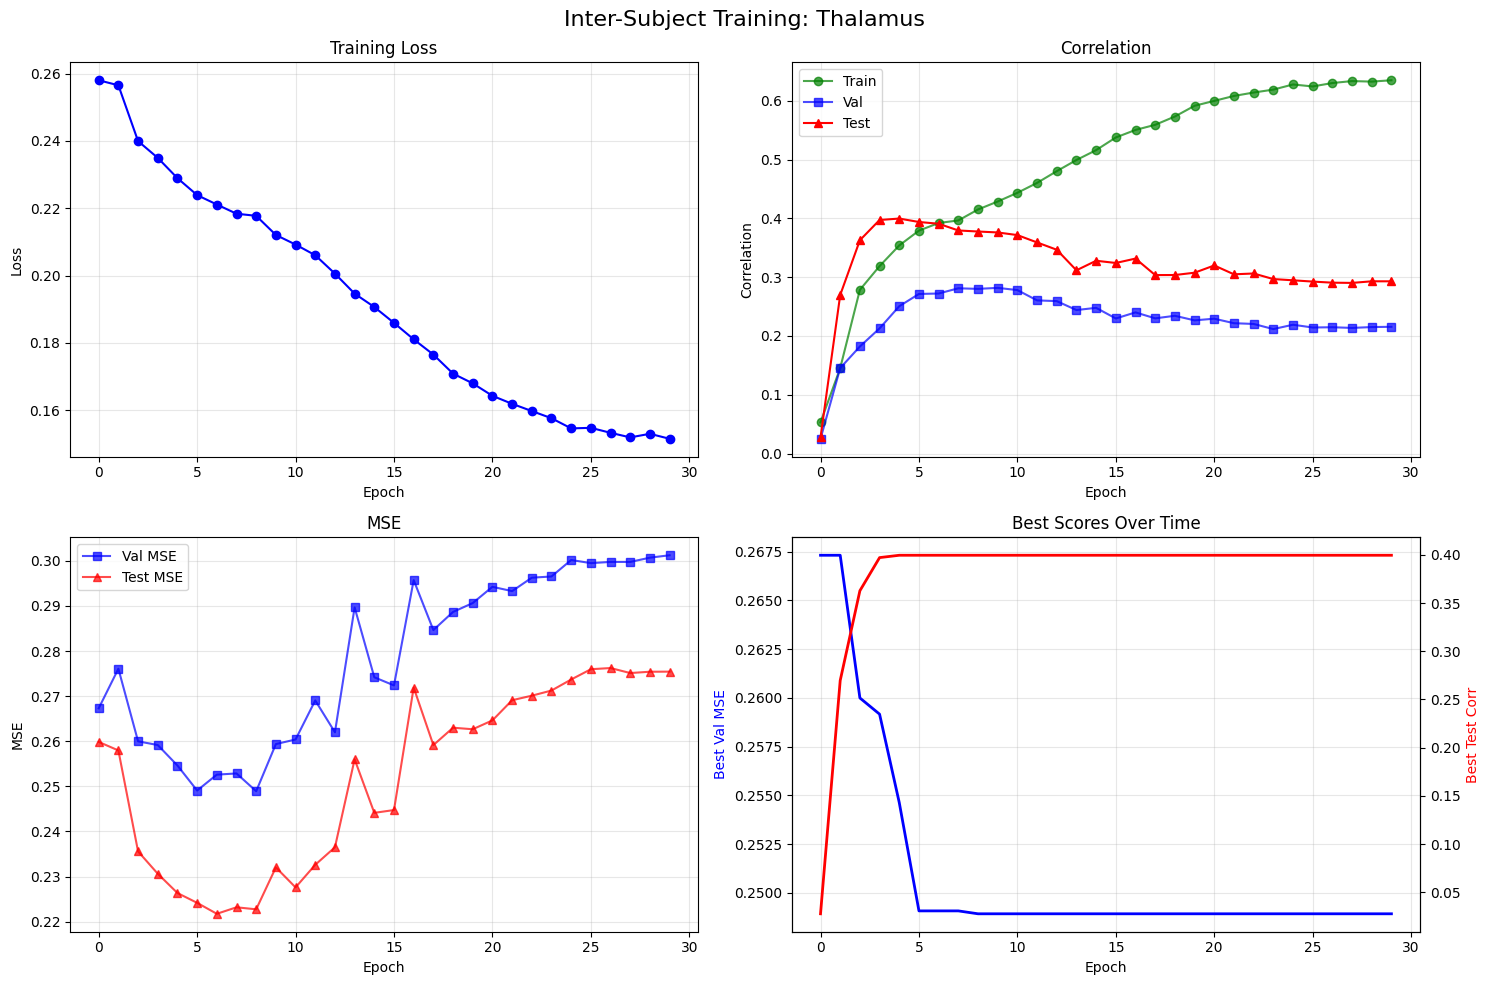

In [21]:
model, history, best_mse, best_corr = train_intersubject_model(args, 'Thalamus')